**Ejercicios Planteados**

Es sabido que, una entidad que presta servicios o productos (pudiera ser una empresa, un banco, una tienda, etcétera) puede mejorar la experiencia de cliente desarrollando productos personalizados en pos de las preferencias y necesidades de cada uno de sus clientes.
El set de datos potencial contiene datos sobre clientes de una institución financiera:

● Customer ID: ID asociado al cliente

● Age: Edad en años del cliente

● Income: Ingreso anual del cliente

● Family: Tamaño del grupo familiar del cliente

● CCAvg: Cupo promedio mensual utilizado en tarjetas de crédito

● Education: Nivel educacional (1 si no es graduado, 2 graduado y 3 si posee estudios especializadoss (magister, doctorado, etcétera)

● Mortgage: Monto de la hipoteca (0 indica que no posee)

● ZIP Code: Código postal del domicilio

En la última campaña a cada cliente se le ofreció un producto personalizado en base a su comportamiento financiero, preferencias, capacidad de pago y necesidades. La variable target corresponde a Personal Loan el cual indica si el cliente tomó o no tomó este producto (¿El cliente aceptó o no el producto ofrecido?), donde 0 indica que el cliente no adquirió el producto y 1 indica que sí lo adquirió.

Es de interés analizar cuáles pudieran ser los perfiles de clientes que tienen mayor probabilidad de aceptar el producto ofrecido, de manera de, identificar a los clientes con dichas características y priorizarlos a ellos en las próximas campañas.

In [1]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import classification_report

### a) Cargue el set de datos utilizando la función read.excel de pandas. ¿Qué columnas le hacen sentido incluir en un modelo para predecir si un cliente tomará o no el producto ofrecido? Si desea eliminar alguna columna, recuerde que puede usar la función drop('nombre columna a eliminar', axis=1).

   Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   25           1      49     91107       4    1.6          1         0   
1   45          19      34     90089       3    1.5          1         0   
2   39          15      11     94720       1    1.0          1         0   
3   35           9     100     94112       1    2.7          2         0   
4   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1  


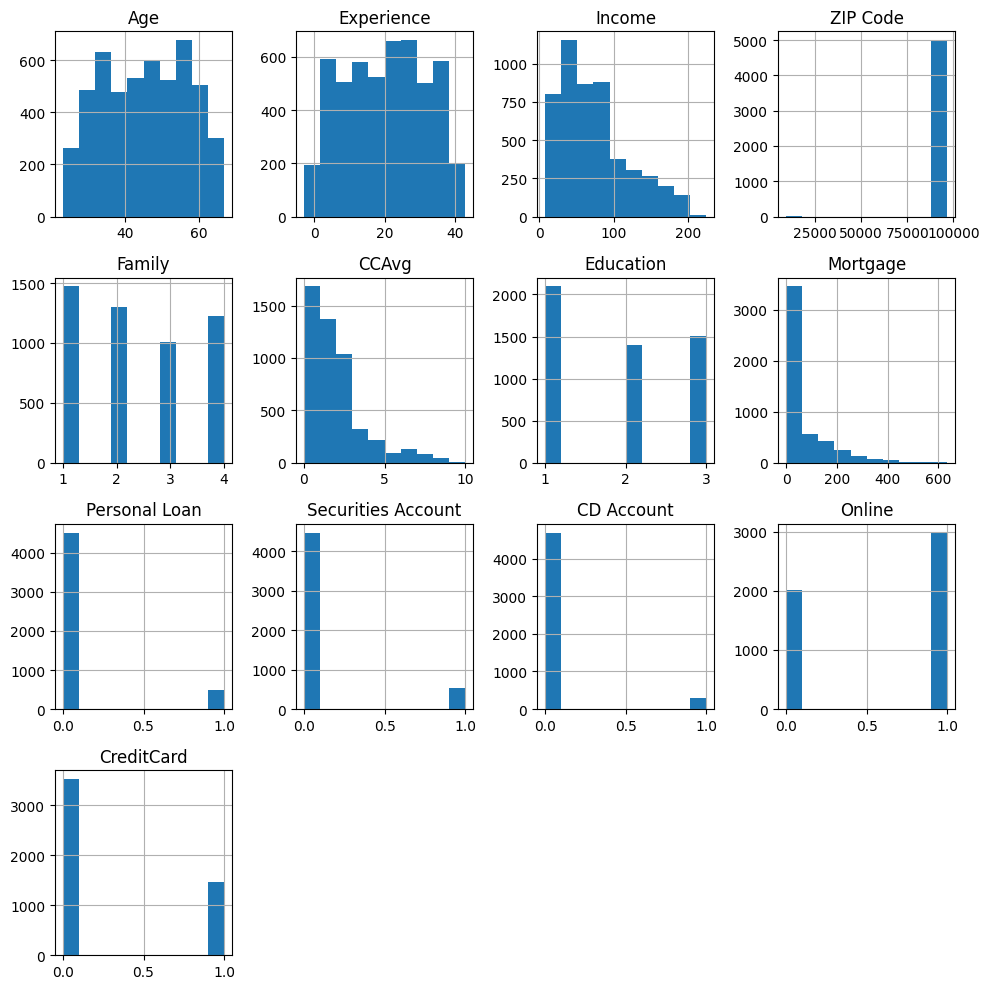

In [3]:
# Importamos Pandas
import pandas as pd
#importar matplotlib.pyplot
import matplotlib.pyplot as plt

#creamos la ruta de Model_creditoPersonal.csv
ruta_credito_personal = 'Model_creditoPersonal.csv'


#leemos el archivo Model_creditoPersonal.csv
credito_personal = pd.read_csv(ruta_credito_personal)

# Eliminar la columna 'ID' no se encuentra necesaria
credito_personal = credito_personal.drop('ID', axis=1)

# Mostrar los primeros datos del DataFrame después de eliminar la columna
print(credito_personal.head())

# 4. Visualizar la distribución de las columnas numéricas
credito_personal.hist(figsize=(10,10))
plt.tight_layout()
plt.show()

### b) Determine cuáles son las variables predictoras que son categorías y obtenga las variables dummies correspondientes para incluirlas en el modelo. Recuerde que puede usar la función get_dummies() de pandas.

In [4]:
#Renombramos las columnas que tienen nombres compuestos por espacios por nombres compuestos por guiones bajos
credito_personal.rename(columns={"ZIP Code":"ZIPCode","Personal Loan":"Personal_Loan","Securities Account":"Securities_Account","CD Account":'CD_Account'},inplace=True)

#mostramos los nombres de las columnas
credito_personal.columns

columnas_a_cambiar = ['Personal_Loan', 'Securities_Account', 'CD_Account', 'Online', 'CreditCard', 'Education']

for columna in columnas_a_cambiar:
    credito_personal[columna] = credito_personal[columna].astype('category')

# Crear variables dummies para la columna 'Education'
credito_personal_dummies = pd.get_dummies(credito_personal, columns=['Education'])

# Convertir las columnas 'Education_1', 'Education_2' y 'Education_3' a enteros
credito_personal_dummies['Education_1'] = credito_personal_dummies['Education_1'].astype(int)
credito_personal_dummies['Education_2'] = credito_personal_dummies['Education_2'].astype(int)
credito_personal_dummies['Education_3'] = credito_personal_dummies['Education_3'].astype(int)

# Renombrar las columnas 'Education_1', 'Education_2' y 'Education_3'
credito_personal_dummies.rename(columns={'Education_1': 'No_Graduado', 'Education_2': 'Graduado', 'Education_3': 'Estudios_Especializados'}, inplace=True)

# Mostrar los primeros datos del DataFrame después de renombrar las columnas
print(credito_personal_dummies.head())

   Age  Experience  Income  ZIPCode  Family  CCAvg  Mortgage Personal_Loan  \
0   25           1      49    91107       4    1.6         0             0   
1   45          19      34    90089       3    1.5         0             0   
2   39          15      11    94720       1    1.0         0             0   
3   35           9     100    94112       1    2.7         0             0   
4   35           8      45    91330       4    1.0         0             0   

  Securities_Account CD_Account Online CreditCard  No_Graduado  Graduado  \
0                  1          0      0          0            1         0   
1                  1          0      0          0            1         0   
2                  0          0      0          0            1         0   
3                  0          0      0          0            0         1   
4                  0          0      0          1            0         1   

   Estudios_Especializados  
0                        0  
1               

### c) Defina en un objeto X las variables predictoras y en Y la variable respuesta Personal Loan. Obtenga los set de entrenamiento y prueba en una proporción 5:1. Recuerde que la función train_test_split() es útil para realizar split simple, además fije una semilla 2021 (random_state=2021 en la función train_test_split()).

In [6]:
from sklearn.model_selection import train_test_split

# Definir las variables predictoras (X) y la variable respuesta (Y)
X = credito_personal_dummies.drop('Personal_Loan', axis=1)
Y = credito_personal_dummies['Personal_Loan']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2021)

# Imprimir las dimensiones de los conjuntos de entrenamiento y prueba
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (4000, 14)
Y_train shape:  (4000,)
X_test shape:  (1000, 14)
Y_test shape:  (1000,)


### d) Obtenga un árbol de decisión con el set de datos de entrenamiento. Obtenga el MSE del modelo en el set de prueba. Muestre el árbol obtenido, ¿qué observa? ¿cuáles podrían ser los problemas de este árbol? ¿qué alternativas pudieran probarse para abordar este problema?

MSE:  0.02


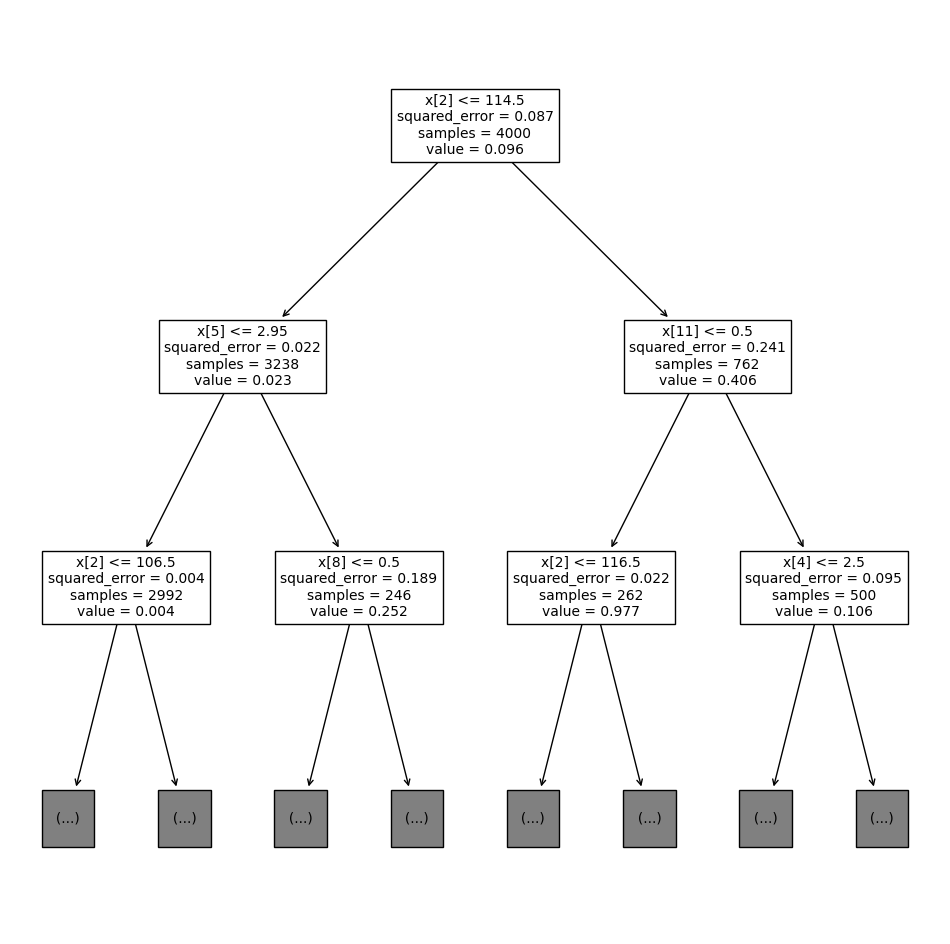

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import tree
import matplotlib.pyplot as plt

# Crear y entrenar el árbol de decisión
arbol = DecisionTreeRegressor(random_state=2021)
arbol.fit(X_train, Y_train)

# Predecir los valores para el conjunto de prueba
Y_pred = arbol.predict(X_test)

# Calcular el MSE
mse = mean_squared_error(Y_test, Y_pred)
print("MSE: ", mse)

# Mostrar el árbol
fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(arbol, max_depth=2, fontsize=10, ax=ax)
plt.show()

La clasificación se fundamenta en la evaluación de los atributos, y los nodos contienen las predicciones correspondientes. A medida que se incrementa la profundidad del árbol, se abarca una mayor complejidad en los datos, aunque se corre el riesgo de sobreajuste.

Para abordar esto:

Ajuste de Profundidad: Experimentar con distintas profundidades para alcanzar un balance entre complejidad y generalización.
Métodos de Ensemble: Explorar técnicas como Random Forest o Gradient Boosting para mejorar la precisión y la resistencia del modelo.
Optimización de Hiperparámetros: Refinar los hiperparámetros del árbol para encontrar la configuración óptima.

### e) Plantee otro árbol de decisión pero definiendo como parámetro de control o prepoda la profundidad máxima del árbol, para esto en la función DecisionTreeClassifier() añada como argumento max_depth=2 (profundidad máxima 2). Obtenga el MSE en el set de prueba y compare con el modelo anterior. Observe el árbol obtenido. Comente.

MSE con profundidad 2:  0.026295539230571242


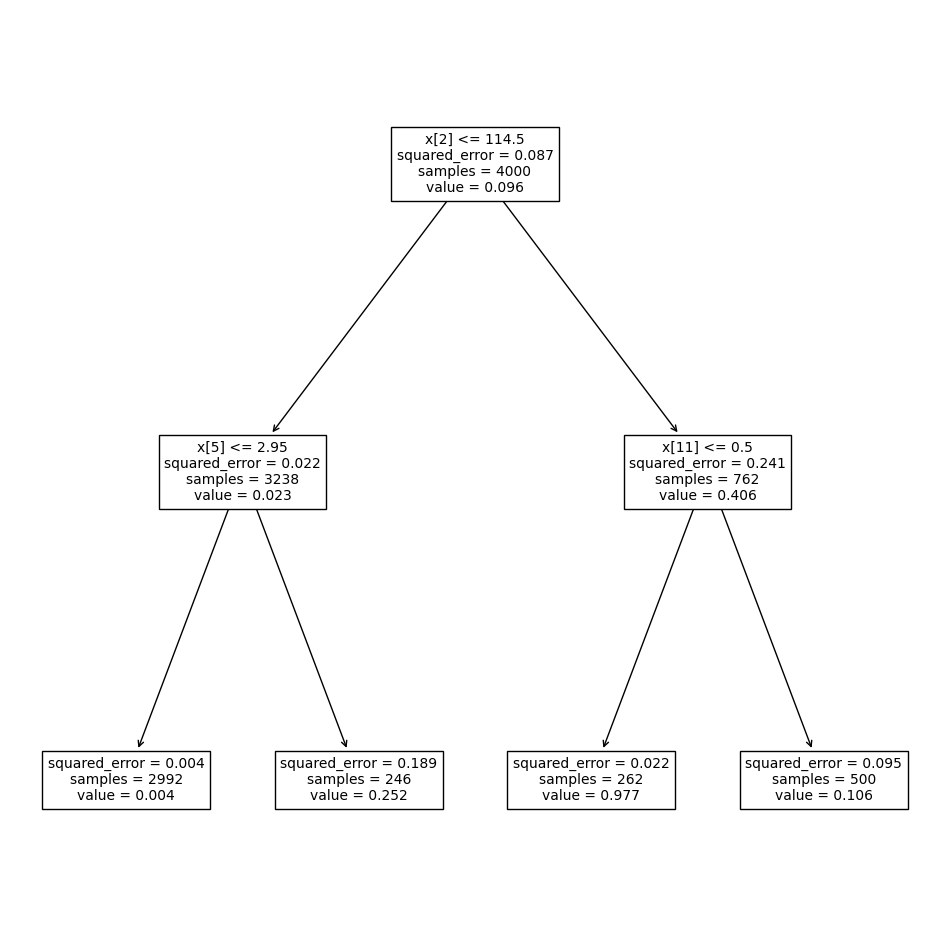

In [8]:
# Crear y entrenar el árbol de decisión con profundidad máxima 2
arbol_profundidad_2 = DecisionTreeRegressor(max_depth=2, random_state=2021)
arbol_profundidad_2.fit(X_train, Y_train)

# Predecir los valores para el conjunto de prueba
Y_pred_profundidad_2 = arbol_profundidad_2.predict(X_test)

# Calcular el MSE
mse_profundidad_2 = mean_squared_error(Y_test, Y_pred_profundidad_2)
print("MSE con profundidad 2: ", mse_profundidad_2)

# Mostrar el árbol
fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(arbol_profundidad_2, fontsize=10, ax=ax)
plt.show()


Observamos que el árbol presenta una profundidad máxima de 2 niveles, con divisiones basadas en los valores de las características, y las predicciones se encuentran en las hojas.

Problemas Potenciales:

Sobreajuste: Debido a su baja profundidad, existe el riesgo de que el árbol esté subajustando los datos, lo que significa que no logra capturar suficiente complejidad en los mismos.

Falta de Generalización: Un árbol poco profundo puede tener dificultades para generalizar a datos no vistos, volviéndose demasiado específico para el conjunto de entrenamiento.

En consecuencia, ajustar la profundidad es una consideración importante para encontrar un equilibrio entre la complejidad y la capacidad de generalización. Esto se abordará en el próximo código.

### f) Busque los mejores valores de los criterios de corte y máxima profundidad para este caso, con 10 validaciones cruzadas, y entregue sus valores (Hint: evalue los hiperparámetros criterion y max_depth)

In [9]:
from sklearn.model_selection import GridSearchCV

# Definir los parámetros para la búsqueda de cuadrícula
parametros = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error'], 'max_depth': range(1, 11)}

# Crear el objeto de búsqueda de cuadrícula
busqueda_cuadricula = GridSearchCV(DecisionTreeRegressor(random_state=2021), parametros, cv=10, scoring='neg_mean_squared_error')

# Ajustar el modelo a los datos
busqueda_cuadricula.fit(X_train, Y_train)

# Imprimir los mejores parámetros
print("Mejores parámetros: ", busqueda_cuadricula.best_params_)
print("Mejor score: ", busqueda_cuadricula.best_score_)

Mejores parámetros:  {'criterion': 'squared_error', 'max_depth': 5}
Mejor score:  -0.014561326022099483


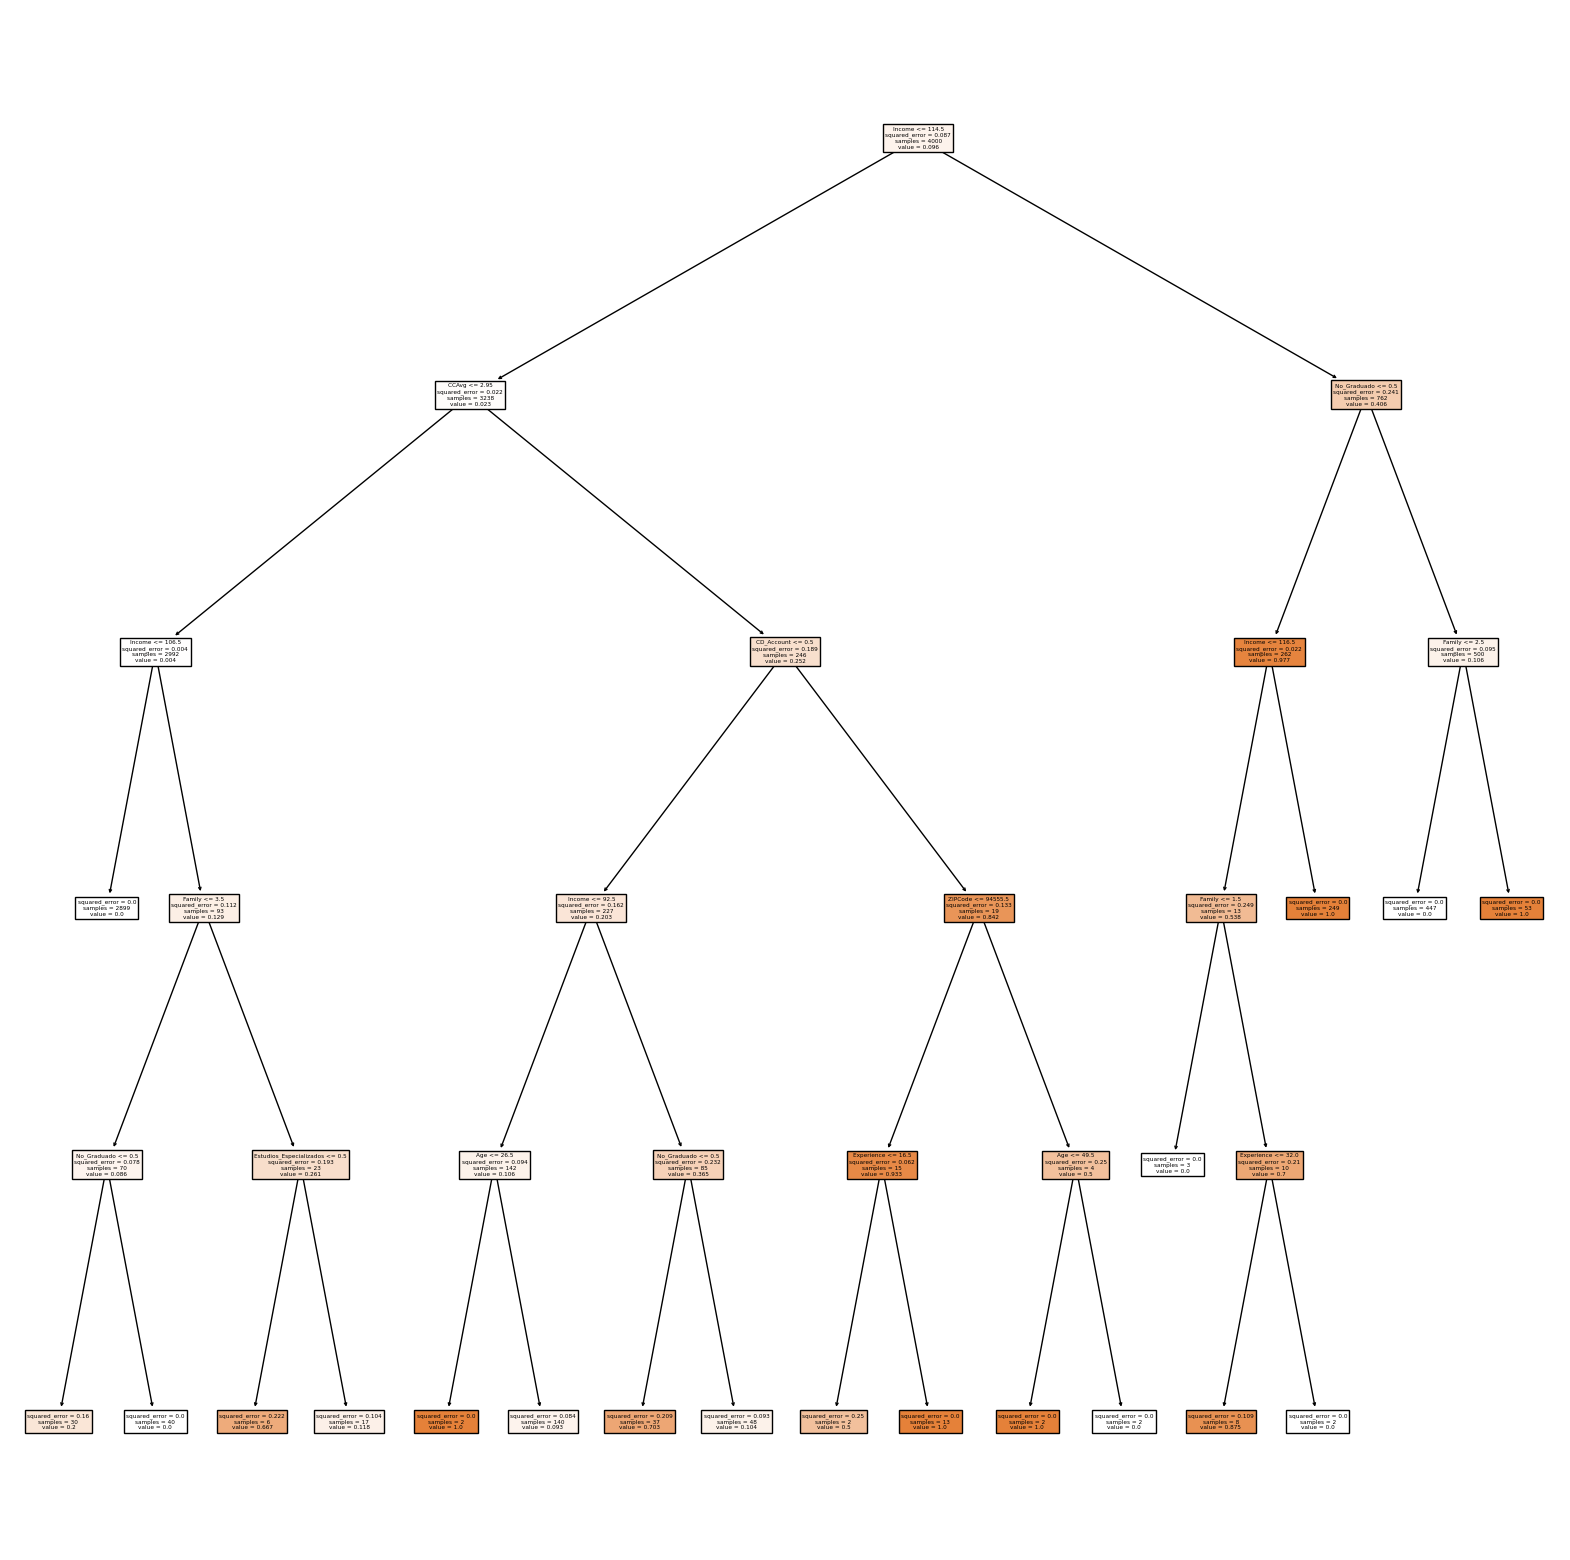

In [11]:
from sklearn.tree import plot_tree

# Asegurar el uso del modelo con los mejores parámetros
mejor_modelo = busqueda_cuadricula.best_estimator_

fig, ax = plt.subplots(figsize=(20, 20))
plot_tree(mejor_modelo, filled=True, feature_names=X.columns, class_names=['No acepta', 'Acepta'], ax=ax)
plt.show()

En síntesis, los parámetros óptimos revelan que se empleó el error cuadrático como criterio y se restringió la profundidad del árbol a 5 niveles. El puntaje negativo indica un aprendizaje del modelo que supera al modelo de referencia. No obstante, para una comprensión más profunda, es esencial tener en cuenta la métrica específica y el contexto del problema.